In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


INTRODUCTION


In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import datetime as date
import requests
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
from multiprocessing import  Pool

Applying Sentiment score

In [ ]:
## https://medium.com/analytics-vidhya/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5

In [ ]:
from tensorflow import keras
import json
from nltk.tokenize import RegexpTokenizer

#loading pre trained model and word index
LSTM_model = keras.models.load_model('/content/drive/MyDrive/CS 2/best_model.hdf5')
index_wrd = json.load(open("/content/drive/MyDrive/CS 2/word_idx.txt"))

In [ ]:
#function to compute sentiment score
def sentiment_score(LSTM_model, txt_data, index_wrd):

    list_txt = []
    pad_seq = len(txt_data)
    pad_len = np.zeros((56,pad_seq))

    dict_txt = [isinstance(item, (str, bytes)) for item in txt_data['title']]
    txt_data = txt_data.loc[dict_txt]

    for i, j in txt_data.iterrows():
        

        txt_col = txt_data['title'][i]
        
        # split the sentence into its words and remove any punctuations.
        tokenzz = RegexpTokenizer(r'\w+')
        list_txt_data = tokenzz.tokenize(txt_col)
        if len(list_txt_data)>56:
          list_txt_data = list_txt_data[:56]
          points = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
        
        # get index for the live stage
        ind_data = np.array([index_wrd[word.lower()] if word.lower() in index_wrd else 0 for word in list_txt_data])
        ind_data_ = np.array(ind_data)

        # padded with zeros of length 56 i.e maximum length
        pad_arr = np.zeros(56)
        pad_arr[:ind_data_.shape[0]] = ind_data_
        data_pad = pad_arr.astype(int)

        list_txt.append(data_pad)

    pad_len = np.asarray(list_txt)
    sent_score = LSTM_model.predict(pad_len, batch_size=64, verbose=0)
    sent_score1 = np.round(np.dot(sent_score, points)/10,decimals=2)
    sent_score2  = []
    for i in sent_score:

        three_top_idx = np.argsort(i)[-3:]
        three_top_scores = i[three_top_idx]
        three_top_wgts = three_top_scores/np.sum(three_top_scores)
        dot_prod = np.round(np.dot(three_top_idx, three_top_wgts)/10, decimals = 2)
        sent_score2.append(dot_prod)

    txt_data['Sentiment_Score'] = pd.DataFrame(sent_score2)

    return txt_data

In [ ]:
org__test_data = pd.read_csv('/content/drive/MyDrive/CS 2/test data/final_data.csv')

In [ ]:
org__test_data = sentiment_score(LSTM_model, org__test_data, index_wrd)

In [ ]:
org__test_data.shape

(16602, 15)

In [ ]:
org__test_data.head()

,Unnamed: 0,created_utc,is_original_content,is_video,num_comments,over_18,subreddit,subreddit_subscribers,title,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score
0,2,1610236635,False,False,5,False,meme,1365808,Have you seen him?,1.0,https://i.redd.it/zg18fetpaea61.jpg,102.0,140.0,2,0.50
1,3,1610236590,False,False,1,False,meme,1365808,Join the fight,1.0,https://i.redd.it/4cfij94laea61.jpg,131.0,140.0,2,0.49
2,4,1610236579,False,False,2,False,meme,1365808,Join the fight,1.0,https://i.redd.it/v3vt23xjaea61.jpg,131.0,140.0,1,0.49
3,7,1610236041,False,False,0,False,meme,1365796,Bye,1.0,https://i.redd.it/ash8bw2x8ea61.jpg,140.0,140.0,2,0.50
4,8,1610236034,False,False,1,False,meme,1365795,Whenever i use the instagram,1.0,https://i.redd.it/99oiaogx8ea61.jpg,140.0,140.0,4,0.45


Extracting text using OCR

In [ ]:
#installing pytesseract
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=d2b2442d471854f1d2fcb119750836571695263897f655a3749c4e0d8b1ed29a
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,664 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
#importing libraries
import cv2 
import pytesseract
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
org__test_data1=org__test_data.sample(n=2000,random_state=1,replace=False)

In [ ]:
org__test_data1.shape

(2000, 15)

In [ ]:
"""
This function will extract text from image. It takes url of image as input and
extracts text from image using pytesseract.
"""
def txt_extraction(urls):
  try:
    image = io.imread(urls)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) 
    alpha_To_extract = r"--oem 3 --psm 11 -c tessedit_char_whitelist= 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    txt_data = pytesseract.image_to_string(image, lang='eng', config=alpha_To_extract)
    return txt_data.replace('\n', ' ')
  except:
    return " "

In [ ]:
def txt(org__test_data1):
  tqdm.pandas(position=0)
  img_txt = org__test_data1.progress_apply(txt_extraction)
  return img_txt

In [ ]:
#This function will help to parallelize our process
def data_parallelism(urls, function, n_cores=4):
    txt_split = np.array_split(urls, n_cores)
    pool = Pool(n_cores)
    img_txt = pd.concat(pool.map(function, txt_split))
    pool.close()
    pool.join()
    return img_txt 

In [ ]:
org__test_data1['img_txt']=0

In [ ]:
org__test_data1['img_txt'] = data_parallelism(org__test_data1['url'], txt)

100%|██████████| 500/500 [14:59<00:00,  1.80s/it]


In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
org__test_data1.to_csv("img_txt_data.csv")

In [ ]:
org__test_data1 = pd.read_csv('/content/drive/MyDrive/CS 2/test data/test_img_txt_data.csv')

In [ ]:
org__test_data1.shape

(2000, 17)

In [ ]:
#combining all text columns to one column and dropping the columns which are being combined
org__test_data1['text'] = org__test_data1['title']+org__test_data1['img_txt']
org__test_data1.drop(['title','img_txt'], axis=1, inplace=True)

In [ ]:
org__test_data1.head()

,Unnamed: 0,Unnamed: 0.1,created_utc,is_original_content,is_video,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score,text
0,9612,15679,1610191527,False,False,5,False,memes,14398009,1.0,https://i.redd.it/xyjz83u8kaa61.jpg,106.0,140.0,1,0.41,The good ol' Lamar tactics to get some b*tches
1,10051,16440,1610181039,False,False,11,False,memes,14396805,1.0,https://i.redd.it/58b2whfep9a61.jpg,91.0,140.0,1,0.31,Sad feminist noises.aS REALIZING mT at fa SREL...
2,14549,24122,1610116249,False,False,4,False,memes,14388900,1.0,https://i.redd.it/2cbx3c4rc4a61.jpg,109.0,140.0,1,0.44,HmmTrying to figure out the family tree after ...
3,10295,16860,1610175444,False,False,3,False,memes,14396276,1.0,https://i.redd.it/d16owmlr89a61.jpg,140.0,140.0,1,0.50,Ah yea I gots to get paidFBI: offers thousands...
4,10092,16505,1610180139,False,False,2,False,memes,14396709,1.0,https://i.redd.it/io0pmc9qm9a61.jpg,139.0,140.0,1,0.55,Brought to you by cornhub


### <br><br>Cleaning text column
<br>

In [ ]:
#importing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [ ]:
#downloading punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#this function will take text as input and will clean it and return cleaned text
def clean_text(text):
    text = re.sub('[^A-Za-z]',' ',text).lower()    #Removing all characters from text except alphabets
    words = word_tokenize(text)
    stopWords = set(stopwords.words('english'))
    ps = PorterStemmer()
    cleanedText = []
    for word in words:
        word = ps.stem(word)
        if word in stopWords or len(word)<=4:      #Removing stopwords and words with length less than 5
            continue
        else:
            cleanedText.append(word)
    return " ".join(set(cleanedText))

In [ ]:
tqdm.pandas(position=0)
#calling function to clean the text
org__test_data1['text'] = org__test_data1['text'].progress_apply(clean_text)

100%|██████████| 2000/2000 [00:01<00:00, 1204.81it/s]


In [ ]:
#new feature containing number of words in text
org__test_data1['num_words'] = org__test_data1['text'].str.split().apply(len)

### **Extracting** **features**

In [ ]:
#importing libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
# load the model


In [ ]:
model_vgg = VGG16()

553476096/553467096 [==============================] - 7s 0us/step


In [ ]:
#this function will take url of image as input and will get the image and convert it to array and return it
def load_image(link, target_size=None):
    import requests
    import shutil
    import os
    
    _, ext = os.path.splitext(link)
    
    r = requests.get(link, stream=True)
    with open('temp.' + ext, 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)
        
    img = image.load_img('temp.' + ext, target_size=target_size)
    return image.img_to_array(img)

In [ ]:
#this function will extract features and their probabilities from image and return them
def extract_feature_from_image(url):
  try:
    im = load_image(url, target_size=(224, 224))
    im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
    im = preprocess_input(im)
    yhat = model.predict(im)
    label = decode_predictions(yhat, top=3)
    obj = []
    pred = []
    for i in label[0]:
      obj.append(i[1])
      pred.append(i[2])
    return [obj,pred]
  
  except:
    return [[""]*3, [0]*3]

In [ ]:
tqdm.pandas(position=0)
test_img_feature_pred = org__test_data1['url'].progress_apply(extract_feature_from_image)

100%|██████████| 2000/2000 [03:03<00:00, 10.89it/s]


In [ ]:
#creating new columns in the dataset to store new features
org__test_data1['img_feature'] = np.empty(2000, dtype=object)
org__test_data1['test_img_feature_pred'] = np.empty(2000, dtype=object)

In [ ]:
#adding newly generated features to the dataset
org__test_data1['img_feature'] = [i[0] for i in test_img_feature_pred]
org__test_data1['test_img_feature_pred'] = [i[1] for i in test_img_feature_pred]

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
org__test_data1.to_csv('df_img_feature_pred_test.csv',index=False)

### <br><br>Dropping Duplicates<br>
In this dataset we have many such rows in which urls are repeated means duplicate urls. Here I am going to drop such data.
<br>

In [ ]:
org__test_data1 = pd.read_csv('/content/drive/MyDrive/CS 2/test data/df_img_feature_pred_test.csv')

In [ ]:
'''
Subreddits with more subscribers tend to get more upvotes, so I am normalizing the number of score by dividing by
the number of subscribers from the respective subreddit where it was posted.
'''
org__test_data1['score'] = org__test_data1['score']/org__test_data1['subreddit_subscribers']

In [ ]:
'''
Checking percentile value of normalized score, so that I can get clear understanding for denoting meme 
as dank or not and making the problem as binary classification problem. 
'''
#checking for top 5 precentile value
top_5_percentile_value = []
for i in range(95,101):
  top_5_percentile_value.append(np.percentile(org__test_data1['score'], i))
print(top_5_percentile_value)

[3.6746631133165257e-06, 4.407719327196755e-06, 5.1428789111236835e-06, 5.872083358574469e-06, 8.081707057620833e-06, 1.6164679880557712e-05]


In [ ]:
between_97_98_percentile_value = []
for i in np.arange(0,1,0.1):
  between_97_98_percentile_value.append(np.percentile(org__test_data1['score'], (97+i)))
print(between_97_98_percentile_value)

[5.1428789111236835e-06, 5.1430859788903685e-06, 5.14361278483233e-06, 5.1438638374824005e-06, 5.8590472892135184e-06, 5.8647172842076674e-06, 5.865545535465291e-06, 5.870672625024258e-06, 5.871094918093215e-06, 5.871599810111333e-06]


In [ ]:
org__test_data1['dank_or_not'] = (org__test_data1['score']>np.percentile(org__test_data1['score'], 97.1)).astype('int')

In [ ]:
org__test_data1['dank_or_not'].value_counts()

0    1942
1      58
Name: dank_or_not, dtype: int64

In [ ]:
org__test_data1.to_csv('org_data_dankornot.csv', index=False)

### <br><br>**Data cleaning and feature encoding**<br>
cleaning the dataset and encoding the categorical features of the dataset.
<br>


In [ ]:
org_data = pd.read_csv('/content/drive/MyDrive/CS 2/test data/test_org_data_dankornot.csv')

### Encoding created_utc column and creating new 'hour' column

The created_utc feature contains the timestamp when the post appeared on Reddit in the Coordinated Universal Time zone (UTC). Since most active Reddit users reside inthe USA, we converted this to North American Central Time Zone.

In [ ]:
from datetime import datetime
from pytz import timezone
import pytz

In [ ]:
fmt = "%Y-%m-%d %H:%M:%S %Z%z"

In [ ]:
datetime_converted = org_data['created_utc'].apply(datetime.fromtimestamp)

In [ ]:
datetime_converted=pd.DatetimeIndex(datetime_converted).tz_localize('UTC').tz_convert('America/New_York')

In [ ]:
org_data['created_utc'] = pd.to_datetime(datetime_converted)

In [ ]:
#creating hour column
org_data['hour'] = org_data['created_utc'].apply(lambda x: x.hour)

In [ ]:
org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype                           
---  ------                 --------------  -----                           
 0   Unnamed: 0             2000 non-null   int64                           
 1   Unnamed: 0.1           2000 non-null   int64                           
 2   created_utc            2000 non-null   datetime64[ns, America/New_York]
 3   is_original_content    2000 non-null   bool                            
 4   is_video               2000 non-null   bool                            
 5   num_comments           2000 non-null   int64                           
 6   over_18                2000 non-null   bool                            
 7   subreddit              2000 non-null   object                          
 8   subreddit_subscribers  2000 non-null   int64                           
 9   upvote_ratio           2000 non-null   fl

In [ ]:
org_data['is_video'].value_counts()

False    2000
Name: is_video, dtype: int64

In [ ]:
org_data.drop(['is_video','Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)

In [ ]:
org_data.head()

,created_utc,is_original_content,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score,text,num_words,img_feature,test_img_feature_pred,dank_or_not,hour
0,2021-01-09 06:25:27-05:00,False,5,False,memes,14398009,1.0,https://i.redd.it/xyjz83u8kaa61.jpg,106.0,140.0,6.945405e-08,0.41,tactic lamar,2,"['', '', '']","[0, 0, 0]",0,6
1,2021-01-09 03:30:39-05:00,False,11,False,memes,14396805,1.0,https://i.redd.it/58b2whfep9a61.jpg,91.0,140.0,6.945986e-08,0.31,srell realiz feminist memat,4,"['', '', '']","[0, 0, 0]",0,3
2,2021-01-08 09:30:49-05:00,False,4,False,memes,14388900,1.0,https://i.redd.it/2cbx3c4rc4a61.jpg,109.0,140.0,6.949802e-08,0.44,alabama figur famili hmmtri,4,"['', '', '']","[0, 0, 0]",0,9
3,2021-01-09 01:57:24-05:00,False,3,False,memes,14396276,1.0,https://i.redd.it/d16owmlr89a61.jpg,140.0,140.0,6.946241e-08,0.50,terrorist paidfbi dollar thousand ident reward...,7,"['', '', '']","[0, 0, 0]",0,1
4,2021-01-09 03:15:39-05:00,False,2,False,memes,14396709,1.0,https://i.redd.it/io0pmc9qm9a61.jpg,139.0,140.0,6.946032e-08,0.55,brought cornhub,2,"['', '', '']","[0, 0, 0]",0,3


In [ ]:
org_data['text'] = org_data['text'].fillna("")

In [ ]:
org_data[org_data['thumbnail_height'].isna()]

,created_utc,is_original_content,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score,text,num_words,img_feature,test_img_feature_pred,dank_or_not,hour
753,2021-01-09 08:53:51-05:00,False,7,False,memes,14398895,1.0,https://i.imgur.com/jOCkMYe.jpg,NaN,NaN,6.944977e-08,0.49,histori written kowalski victor,4,"['', '', '']","[0, 0, 0]",0,8
943,2021-01-09 02:53:29-05:00,False,1,False,memes,14396549,1.0,https://i.vgy.me/Thw8l9.png,NaN,NaN,6.946109e-08,0.45,discov,1,"['', '', '']","[0, 0, 0]",0,2


In [ ]:
print(org_data['thumbnail_height'].value_counts())
print()
print(org_data['thumbnail_width'].value_counts())

140.0    1074
78.0       50
105.0      45
139.0      29
138.0      28
         ... 
60.0        1
42.0        1
55.0        1
29.0        1
66.0        1
Name: thumbnail_height, Length: 90, dtype: int64

140.0    1998
Name: thumbnail_width, dtype: int64


In [ ]:
org_data['thumbnail_height'].fillna(org_data['thumbnail_height'].mode().iloc[0], inplace=True)
org_data['thumbnail_width'].fillna(org_data['thumbnail_width'].mode().iloc[0], inplace=True)

In [ ]:
org_data.describe()

,num_comments,subreddit_subscribers,upvote_ratio,thumbnail_height,thumbnail_width,score,Sentiment_Score,num_words,dank_or_not,hour
count,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.0,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000
mean,7.293500,9.206592e+06,0.981370,125.087000,140.0,8.949684e-07,0.455590,3.558500,0.029000,11.62250
std,28.794547,6.381389e+06,0.063421,21.745824,0.0,1.557411e-06,0.104441,3.919089,0.167848,6.19808
min,0.000000,1.354604e+06,0.340000,20.000000,140.0,0.000000e+00,0.060000,0.000000,0.000000,0.00000
25%,1.000000,1.361507e+06,1.000000,112.000000,140.0,6.949545e-08,0.410000,1.000000,0.000000,7.00000
50%,3.000000,1.438824e+07,1.000000,140.000000,140.0,7.328074e-07,0.480000,3.000000,0.000000,12.00000
75%,6.000000,1.439493e+07,1.000000,140.000000,140.0,7.380676e-07,0.500000,5.000000,0.000000,16.00000
max,554.000000,1.440314e+07,1.000000,140.000000,140.0,1.616468e-05,0.810000,67.000000,1.000000,23.00000


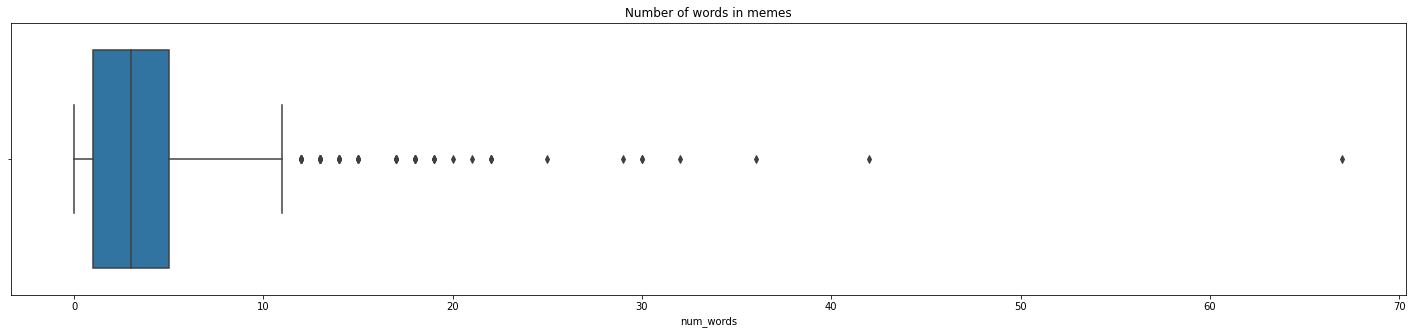

In [ ]:
plt.figure(figsize=(25,5))
sns.boxplot(org_data['num_words'])
plt.title('Number of words in memes')
plt.show()

In [ ]:
np.percentile(org_data['num_words'],99.9)

36.00600000000122

In [ ]:
for i in range(90,101):
  print(i,'percentile : ',np.percentile(org_data['num_words'],i))

90 percentile :  7.0
91 percentile :  8.0
92 percentile :  8.0
93 percentile :  9.0
94 percentile :  9.0
95 percentile :  10.0
96 percentile :  11.0
97 percentile :  11.0
98 percentile :  13.019999999999982
99 percentile :  18.0
100 percentile :  67.0


In [ ]:
for i in np.arange(99,100.1,0.1):
  print(i,'percentile : ',np.percentile(org_data['num_words'],i))

99.0 percentile :  18.0
99.1 percentile :  18.0
99.19999999999999 percentile :  18.00799999999981
99.29999999999998 percentile :  19.0
99.39999999999998 percentile :  20.00599999999963
99.49999999999997 percentile :  22.0
99.59999999999997 percentile :  22.01199999999767
99.69999999999996 percentile :  29.00299999999902
99.79999999999995 percentile :  30.003999999998086
99.89999999999995 percentile :  36.00599999999304
99.99999999999994 percentile :  66.99999999997158


In [ ]:
org_data = org_data[org_data['num_words']<=75]

In [ ]:
org_data.shape[0]

2000

In [ ]:
org_data.drop(['created_utc','subreddit','url'], axis=1, inplace=True)

In [ ]:
org_data['is_original_content'] = org_data['is_original_content'].astype('int')

In [ ]:
org_data['over_18'] = org_data['over_18'].astype('int')

In [ ]:
top_5_features = org_data[org_data['score']>np.percentile(org_data['score'],95)]['img_feature']
least_5_features = org_data[org_data['score']<np.percentile(org_data['score'],5)]['img_feature']

In [ ]:
#list data are in form of string, converting them to list
from ast import literal_eval
top_5_features = top_5_features.apply(literal_eval)
least_5_features = least_5_features.apply(literal_eval)

In [ ]:
#storing all the words present im top 5% features
top_features_list=[]
for value in top_5_features:
    top_features_list.extend(value)

In [ ]:
#storing all the words present im bottom 5% features
least_features_list=[]
for value in least_5_features:
    least_features_list.extend(value)

Getting top 10 **shared** objects

In [ ]:
top_objects = pd.DataFrame(top_features_list).value_counts()[:11].index.to_frame(index=False)[0]

In [ ]:
least_objects = pd.DataFrame(least_features_list).value_counts()[:10].index.to_frame(index=False)[0]

In [ ]:
common_objs = set(top_objects).intersection(set(least_objects))

Getting top 10 **most popular** objects which are not shared

In [ ]:
top_objects = pd.DataFrame(top_features_list).value_counts()[:0].index.to_frame(index=False)[0]

In [ ]:
least_objects = pd.DataFrame(least_features_list).value_counts()[:10].index.to_frame(index=False)[0]

In [ ]:
most_pop_objcts = set(top_objects) - set(least_objects)

Getting top 10 **least popular** objects which are not shared

In [ ]:
least_objects = pd.DataFrame(least_features_list).value_counts()[-10:].index.to_frame(index=False)[0]

In [ ]:
top_objects = pd.DataFrame(top_features_list).value_counts()[:47].index.to_frame(index=False)[0]

In [ ]:
least_pop_objcts = set(least_objects) - set(top_objects)

In [ ]:
#showing top 10 words in top 5%, bottom 5% and shared data
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Shared",list(common_objs))
x.add_column("Top 5%",list(most_pop_objcts))
x.add_column("Bottom 5%",list(least_pop_objcts))
print(x)

Exception: ignored

In [ ]:
#list in img_feature column are in form of string, converting them to list
org_data['img_feature'] = org_data['img_feature'].apply(literal_eval)

In [ ]:
#now combining all elements of list as one string
org_data['img_feature'] = org_data['img_feature'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
#storing all the 30 words so that we can use them during bag of words creation
vocab_word = []
#vocab_word.extend(list(most_pop_objcts))
vocab_word.extend(list(least_pop_objcts))
vocab_word.extend(list(common_objs))

In [ ]:
#using countvectorizer to create bag of words
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
Countvector = CountVectorizer(vocabulary=vocab_word)

In [ ]:
image_fea_vector = Countvector.fit_transform(org_data['img_feature'])

In [ ]:
image_fea_vector = pd.DataFrame(image_fea_vector.toarray(),columns=Countvector.get_feature_names())

In [ ]:
#joining all bag of word features to original dataset
org_data = org_data.reset_index().join(image_fea_vector)

In [ ]:
org_data.drop(['index','img_feature'], axis=1, inplace=True)

In [ ]:
#saving the dataset
org_data.to_csv('test_df_clean.csv', index=False)

In [ ]:
org_data = pd.read_csv('/content/drive/MyDrive/CS 2/test data/test_df_clean.csv')

In [ ]:
org_data.shape

(2000, 15)

In [ ]:
org_data21 = pd.read_csv('/content/drive/MyDrive/CS 2/df_clean.csv')

In [ ]:
org_data21.shape

(12995, 37)